In [411]:
import matplotlib.pyplot as plt
import tweepy
import pandas as pd
from textblob import TextBlob

consumer_key = 
consumer_secret = 
access_token = 
access_token_secret = 



auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

search_words = "bitcoin"
max_tweets = 200
tweets_list = []
time_list = []
tweets = tweepy.Cursor(api.search,
              q=search_words,
              lang="en",tweet_mode='extended'
              ).items(max_tweets)
for tweet in tweets:
    tweets_list.append(tweet.full_text)
    time_list.append(tweet.created_at)
# print(tweets_list[3])


In [412]:
bitcoin_tweets = pd.DataFrame({'tweets': tweets_list, 'time': time_list}) #create dataframe from obtained tweets
bitcoin_tweets.to_csv('tweet_with_time1.csv', index = False, encoding = 'utf-8', mode='a', header=None)
bitcoin_tweets = pd.read_csv('tweet_with_time1.csv')

Tweets preprocessing

In [663]:
import numpy as np
import re

In [650]:
def remove_pattern(input_txt, pattern): #function to remove mentions
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt  

bitcoin_tweets["tweets"] = np.vectorize(remove_pattern)(bitcoin_tweets["tweets"], "@[\w]*") #remove mentions  


In [665]:
def preprocess_tweets(tweets_dataframe):
    tweets_dataframe["tweets"] = tweets_dataframe[~tweets_dataframe["tweets"].str.contains("RT @", na=False)] #Remove "RT @"
    tweets_dataframe["tweets"]  = tweets_dataframe["tweets"].apply(lambda x: re.split('https:\/\/.*', str(x))[0]) #remove links
    tweets_dataframe["tweets"]  = tweets_dataframe["tweets"].str.replace(r'(?:_|[^\w\s])+', '') #remove special characters
    tweets_dataframe.drop_duplicates(subset ="tweets", keep = False, inplace = True)  #remove duplicates
    tweets_dataframe.dropna(inplace= True)
    return(tweets_dataframe)

processed_bitcoin_df = preprocess_tweets(bitcoin_tweets)

Sentiment Analysis

In [656]:
processed_bitcoin_df[['polarity', 'subjectivity']] = \
                                    processed_bitcoin_df["tweets"] \
                                    .apply(lambda Text: pd.Series(TextBlob(TextBlob).sentiment))

In [617]:
processed_bitcoin_df.to_csv('tweets_sentiments.csv', encoding='utf-8', index=False)

In [619]:
processed_bitcoin_df = processed_bitcoin_df[['tweets', 'time', 'polarity' ]]
processed_bitcoin_df['date'] = processed_bitcoin_df['time'].str[:10] # Seperate dates
processed_bitcoin_df['exact_time'] = processed_bitcoin_df['time'].str[-8:] #separate time
processed_bitcoin_df = processed_bitcoin_df[['tweets','date', 'exact_time', 'polarity']] #drop unecessary columns

In [470]:
processed_bitcoin_df['date'] =  pd.to_datetime(processed_bitcoin_df['date'], infer_datetime_format=True) #convert str to date time to take average daily price

In [473]:
#daily average sentiments
daily_average_sentiments = processed_bitcoin_df.groupby(
    [processed_bitcoin_df.date.dt.strftime('%Y %b %d'), ]
)['polarity'].mean().reset_index(name='Average_sentiment')

In [493]:
daily_sentiments

,date,Majority_Sentiment
0,2021-08-16,positive
1,2021-08-17,positive
2,2021-08-18,positive
3,2021-08-19,positive
4,2021-08-20,positive
5,2021-08-21,positive
6,2021-08-22,positive
7,2021-08-23,positive


In [494]:
#hourly majority sentiments

hourly_sentiments = processed_bitcoin_df.groupby(
    ['date',pd.to_datetime(bitcoin_df.exact_time).dt.strftime('%H:00')]
)['polarity'].mean().reset_index(name='hourly_average_sentiment')
# hourly_sentiments.insert(0, 'date','')
# hourly_sentiments['date'] = processed_bitcoin_df['date']
# times = pd.to_datetime(processed_bitcoin_df['exact_time']).dt.strftime('%H:00')
# hourly_sentiments = (processed_bitcoin_df.groupby(['date', times], sort=False)['sentiment'].apply(f)
#          .reset_index(name='Majority_Sentiment'))

In [587]:
hourly_sentiments

,date,exact_time,hourly_average_sentiment
0,2021-08-16,11:00,0.112801
1,2021-08-17,02:00,0.135982
2,2021-08-18,15:00,0.074118
3,2021-08-18,16:00,0.128611
4,2021-08-19,08:00,0.127185
5,2021-08-19,10:00,0.136063
6,2021-08-20,04:00,0.118341
7,2021-08-21,09:00,0.131932
8,2021-08-22,11:00,0.092163
9,2021-08-22,14:00,0.174150


Scrap Bitcoin Prices

In [589]:
import requests
import csv
import json
# "http://api.coincap.io/v2/assets/bitcoin/history?interval=m1&start=1592585794000&end=1613753794000"

url = "http://api.coincap.io/v2/assets/bitcoin/history?interval=m1&start=1629367200000&end=1629370740000"

payload = {}
headers= {}

response = requests.request("GET", url, headers=headers, data = payload)

json_data = json.loads(response.text.encode('utf8'))

bitcoin_data = json_data["data"]
bitcoin_price_df = pd.DataFrame(bitcoin_data)

In [591]:
#preprocess scraped bitcoin 
def preprocess_bitcoin(data_frame):
    data_frame['new_time'] = pd.to_datetime(bitcoin_price_df['time'],unit='ms') #convert unix time to datetime
    data_frame['new_time'] = bitcoin_price_df['new_time'].astype(str) #convert datetime to string
    data_frame['date'] = bitcoin_price_df['new_time'].str[:10] # Seperate dates
    data_frame['time'] = bitcoin_price_df['new_time'].str[-8:] #separate time
    data_frame = bitcoin_price_df[['priceUsd', 'time', 'date']] #remove unecessary columns
    return(data_frame)

bitcoin_df = preprocess_bitcoin(bitcoin_price_df)

In [595]:

bitcoin_price_df['date'] =  pd.to_datetime(bitcoin_price_df['date'], infer_datetime_format=True) #convert str to date time to take average daily price

In [598]:
#calculate daily average price
average_daily_price = bitcoin_price_df.groupby(
    [bitcoin_price_df.date.dt.strftime('%Y %b %d'), ]
)['priceUsd'].mean().reset_index(name='Average_price')
#calculate average hourly price
average_hourly_price = bitcoin_price_df.groupby(
    ['date',pd.to_datetime(bitcoin_price_df.time).dt.strftime('%H:00')]
)['priceUsd'].mean().reset_index(name='hourly_average_price')
average_hourly_price

,date,time,hourly_average_price
0,2021-08-16,11:00,47532.971726
1,2021-08-17,02:00,46315.487808
2,2021-08-18,15:00,45380.176227
3,2021-08-18,16:00,45753.561783
4,2021-08-19,08:00,44694.015394
5,2021-08-19,10:00,44651.912586
6,2021-08-20,04:00,47140.692563
7,2021-08-21,09:00,48882.018868
8,2021-08-22,11:00,49189.256367
9,2021-08-22,14:00,48763.474557


In [560]:
#concatinate daily average sentiments DF and daily average price DF
daily_comperison = pd.concat([average_daily_price['date'],\
                average_daily_price['Average_price'], \
                daily_average_sentiments['Average_sentiment']], \
                axis=1, keys=['date','average_price', 'average_Sentiments'])

daily_comperison

,date,average_price,average_Sentiments
0,2021 Aug 16,47532.971726,0.112801
1,2021 Aug 17,46315.487808,0.135982
2,2021 Aug 18,45566.869005,0.118137
3,2021 Aug 19,44694.015394,0.131480
4,2021 Aug 20,47140.692563,0.118341
5,2021 Aug 21,48882.018868,0.131932
6,2021 Aug 22,48813.583846,0.128288
7,2021 Aug 23,50275.299894,0.116067
8,2021 Aug 24,49299.950123,0.177182


In [565]:
#scale down prices between 0 and 1

a, b = 0, 1
x, y = daily_comperison.average_price.min(), daily_comperison.average_price.max()
daily_comperison['scaled_price'] = (daily_comperison.average_price - x) / (y - x) * (b - a) + a
print (daily_comperison)

          date  average_price  average_Sentiments  scaled_price
0  2021 Aug 16   47532.971726            0.112801      0.508656
1  2021 Aug 17   46315.487808            0.135982      0.290520
2  2021 Aug 18   45566.869005            0.118137      0.156389
3  2021 Aug 19   44694.015394            0.131480      0.000000
4  2021 Aug 20   47140.692563            0.118341      0.438372
5  2021 Aug 21   48882.018868            0.131932      0.750366
6  2021 Aug 22   48813.583846            0.128288      0.738104
7  2021 Aug 23   50275.299894            0.116067      1.000000
8  2021 Aug 24   49299.950123            0.177182      0.825246


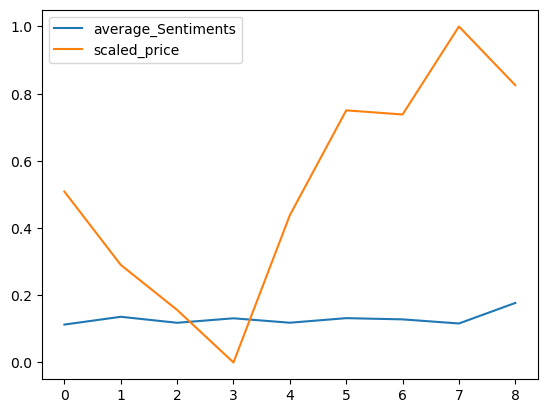

In [567]:
daily_comperison[['average_Sentiments','scaled_price']].plot()
plt.show()

In [600]:
#Hourly Comparison
hourly_comperison = pd.concat([average_hourly_price['time'],\
                    average_hourly_price['hourly_average_price'], \
                    hourly_sentiments['hourly_average_sentiment']], \
                    axis=1, keys=['time','average_price', 'average_Sentiments'])

hourly_sentiments

,date,exact_time,hourly_average_sentiment
0,2021-08-16,11:00,0.112801
1,2021-08-17,02:00,0.135982
2,2021-08-18,15:00,0.074118
3,2021-08-18,16:00,0.128611
4,2021-08-19,08:00,0.127185
5,2021-08-19,10:00,0.136063
6,2021-08-20,04:00,0.118341
7,2021-08-21,09:00,0.131932
8,2021-08-22,11:00,0.092163
9,2021-08-22,14:00,0.174150


In [601]:
average_hourly_price

,date,time,hourly_average_price
0,2021-08-16,11:00,47532.971726
1,2021-08-17,02:00,46315.487808
2,2021-08-18,15:00,45380.176227
3,2021-08-18,16:00,45753.561783
4,2021-08-19,08:00,44694.015394
5,2021-08-19,10:00,44651.912586
6,2021-08-20,04:00,47140.692563
7,2021-08-21,09:00,48882.018868
8,2021-08-22,11:00,49189.256367
9,2021-08-22,14:00,48763.474557


In [602]:
a, b = 0, 1
x, y = hourly_comperison.average_price.min(), daily_comperison.average_price.max()
hourly_comperison['scaled_price'] = (hourly_comperison.average_price - x) / (y - x) * (b - a) + a


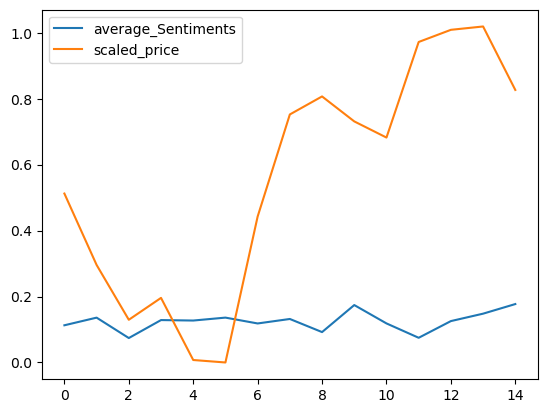

In [604]:
hourly_comperison[['average_Sentiments','scaled_price']].plot()
plt.show()